In [1]:
#import sys
#sys.path.append('C:\\Users\\mabdalla\\OneDrive - ec-lyon.fr\\Documents\\Python Scripts\\packages')
import torch
import numpy as np
import photontorch as pt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from photontorch.environment import current_environment
import matplotlib.pyplot as plt
from scipy.signal import butter#, lfilter
import pandas as pd 
from photontorch import BoundedParameter
from ipywidgets import interact
from tqdm.notebook import trange
torch.__version__

'1.8.1'

### Components: PD, MZ Intensity Modulator, Electronic combiner, Optical Attenuator, Readout, CW Laser

In [2]:
class attenuator(pt.Component):
    """
    The optical attenuator is a 2 port component that attenuates the signal. It is bounded from 0 to 1.
    The attenuation is trainable.
    
    Terms: 
    Optical  0 ----- 1  Optical
            
    """      
    num_ports = 2
    
    def __init__(
    self,
    trainable = True,
    attenuation = 0.0,
    name=None,
    ): 
        #self.attenuation = float(attenuation)
        super(attenuator, self).__init__(name=name)
        if trainable:
            self.attenuation = BoundedParameter(
            data=torch.tensor(attenuation, device=self.device),
            bounds=(0.0, 1.0),
            requires_grad=True,
            )
        else:
            self.attenuation = pt.Buffer(
            data=torch.tensor(attenuation, device=self.device), requires_grad=False
            )
    
    def set_S(self, S):
        S[0,:,0,1] = S[0,:,1,0] = (1.0-self.attenuation) ** 0.5

        return S

In [3]:
class cw_laser(pt.Component):
    """
    A CW Laser used when multiple sources are desired in a network. Note: When linking, terminate the component's 
    0 port.

    Terms: 
        0 ---- 1 
    
    """    
    num_ports = 2
    
    def __init__(
        self,
        Power = 1,  #Input the laser power here
        delay=0,
        name = None,  
        ):
        
        super(cw_laser,self).__init__(name=name) 
        self.Power = float(Power)
        self.delay = float(delay)
            
    def action(self, t, x_in, x_out):
        #Input port actions
        a_in, _ = x_in
        x_out[0] = a_in  #Nothing happens to input node
        
        if t<self.delay:
            x_out[1,0] = 0.0001  #Zero noise floor
        else:
            x_out[1,0] = self.Power ** 0.5
        
        x_out[1,1] = 0  #no phase information, this is a real source
        
        #print(x_out[1,0])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

In [4]:
class mask(pt.Component):
    """
    A masking signal that is either binary or from a standard distribution.

    Terms: 
        0 ---- 1 
    
    """       
    num_ports = 2
    
    def __init__(
        self,
        m_length = 5,
        mask_vector=torch.ones(5),
        name=None,
    ):
        
        super(mask,self).__init__(name=name)
        self.m_length = int(m_length)
        self.mask_vector = mask_vector
        self.counter = -1
        
        #print(x)
        
        
    def action(self,t,x_in,x_out):
        a_in, _ = x_in
        
        x_out[0] = a_in  #Nothing happens to input node        
        
        self.counter = self.counter + 1
            
        x_out[1] = a_in * self.mask_vector[self.counter]
        #print(x_out[1])
        if self.counter == self.m_length-1:
            self.counter = -1
            
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self,S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

### Constructing the Reservoir Circuit

In [5]:
class dc_reservoir(pt.Network):
    def __init__(self, las_pow = 1, attenuation=0.1, wg_delay=1e-9, wg_phase=0, ring_per=2*np.pi*6.75e-6, tr=0.9,
                 nodes=25, mask_vector=torch.ones(10, dtype=torch.float64), 
                 weights = 0.1*torch.rand(25, dtype=torch.float64),
                 neff = 2.2111, ng = 2.2637):
        super(dc_reservoir, self).__init__()
        self.src = pt.Source()
        self.det = pt.Detector()
        self.mask = mask(m_length=nodes, mask_vector = mask_vector)
        self.att = attenuator(attenuation=attenuation, trainable = False) 
        self.laser = cw_laser(Power=las_pow, delay=0) 
        self.term = pt.Term()
        self.dc1 = pt.DirectionalCoupler(1-tr)
        self.wg1 = pt.Waveguide(ring_per, loss=0, neff=neff)
        self.fb = pt.Waveguide(neff= neff, length=299792458*wg_delay/2.2637, phase=wg_phase, trainable = False)
        self.link('src:0', '0:mask:1', '3:dc1:2', '0:det')
        self.link('dc1:1', '0:fb:1', '0:att:1', '0:dc1:1')
print(torch.where(dc_reservoir().free_ports_at)[0])

Buffer containing:
tensor([], dtype=torch.int64)


## Simulation Setup

In [6]:
'''------- Generate uniform distribution between 0 and 0.5 -------'''

class Narma10Generator(np.random.RandomState):
    def __call__(self, N, B=1):
        u = (0.5-0)*self.rand(N,B)
        return u

In [7]:
'''----- NARMA10 TASK -----'''

def narma10_jaeger(x):
    
    size = len(x)
    y = torch.zeros(x.shape)
    for n in range(10,size):
        y[n] = 0.3*y[n-1] + 0.05*y[n-1]*(y[n-1]+y[n-2]+y[n-3] \
            +y[n-4]+y[n-5]+y[n-6]+y[n-7]+y[n-8]+y[n-9]+y[n-10]) \
            + 1.5*x[n-10]*x[n-1] + 0.1
    return y

TARGET = narma10_jaeger 

In [8]:
'''----- SIMULATION PARAMETERS -----'''

# ----- General Parameters -----
c = 299792458.0                           #[m/s] speed of light
Rb = 1e9                                  #[1/s] bitrate
Rs = 25*Rb                                #[1/s] samplerate
fc = 2e9                                  #[1/s] cutoff frequency for bit generation
wl0 = 1550e-9                             #[m] center wavelength
neff = 2.2111     #1.4440                 #[1] effective index of fiber spool
ng = 2.2637       #1.4626                 #[1] group index of fiber spool
neff_mzm = 2.2111                         #[1] Effective index of lithium niobate (modulator)
ng_mzm = 2.2637                           #[1] Group index of lithium niobate (modulator)
N = 3200                                  #[1] number of bits per bit stream
B = 1                                     #[1] Number of bit streams in training batch
sim_time = N/Rb                           #[s] Simulation time 
wl = 1.55e-6                              #[m] Center Wavelength
Str, Sva, Ste = (10, 2, 3)                #[1] train seed, validation seed, test seed
Lr = (1/Rb) * (c/ng)                      #[m] reference length (distance a bit travels during one bit period)
device = torch.device("cpu")              #default device used
torch.set_default_dtype(torch.float32)    #default dtype used
torch.manual_seed(3)                      #pytorch seed
np.random.seed(42)                        #numpy seed


# ----- Reservoir Parameters -----
las_pow = 1                               #[1] Laser Power
wg_delay = 1.0e-9 #equivalent to k=1      #[s] Delay tao(Along with group index below)
fb_att = 0.1                              #[1] Feedback attenuation (strength)
fb_phase=0                                #[1] Feedback phase
Nodes = np.int(Rs/Rb)                     #[1] Number of virtual nodes in the reservoir
mask_vector = 0.1*torch.rand(Nodes)       #Input mask

In [9]:
'''----- BITSTREAM GENERATION -----'''
streamgen = pt.BitStreamGenerator(bitrate=Rb, samplerate=Rs, cutoff_frequency=fc, device=device)

In [10]:
'''----- BITSTREAMS -----'''

# train streams
trbits = Narma10Generator(seed=Str)(N, 1) # N bits per train stream, B train streams per batch.
trstream = streamgen(trbits)
trtarget = streamgen(TARGET(trbits))
trtarget_np = trtarget.numpy()

# validation streams
vabits = Narma10Generator(seed=Sva)(N, 1) # N bits per validation stream, 1 validation stream per batch.
vastream = streamgen(vabits)
vatarget = streamgen(TARGET(vabits))

# test streams
tebits = Narma10Generator(seed=Ste)(N, 1) # N*B bits per teststream
testream = streamgen(tebits)
tetarget = streamgen(TARGET(tebits)) 

# Simulation time tensor
t = np.arange(trstream.shape[0], dtype=np.float32)*(1/Rs)

In [11]:
'''----- Mean Squared Error Function -----'''
def mse_new(target,predicted,Bits):
    mse = 0
    for i in range(target.size):
        mse = mse+(target[i] - predicted[i])**2
    mse = mse/Bits
    return mse

## Training for Narma10 Task

## Testing at the training wavelength for Validation set

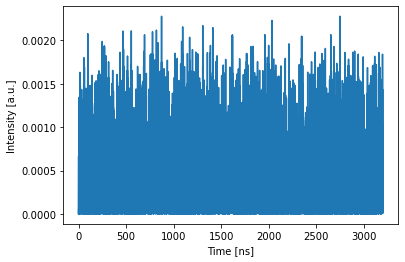

 phase: 0, attenuation: 0, transmission = 0.5, nmse: 0.15109367303571142


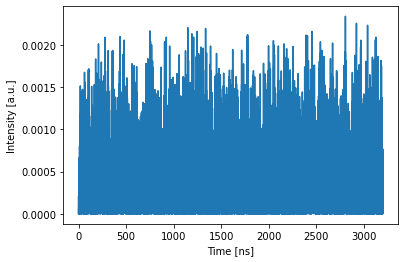

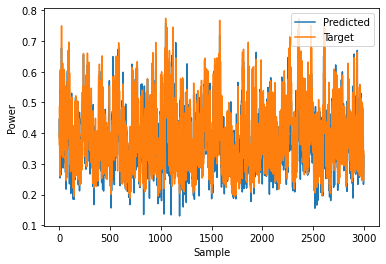

 phase: 0, attenuation: 0, transmission = 0.5, nmse: 0.1668780432916116


In [13]:
'''----- Training -----'''
wg_phase_=0
tr_=0.5
fb_att_=0
wg_delay_=1.0e-9
Bits=N

ring_res_test = dc_reservoir(las_pow=las_pow, attenuation=fb_att_, wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes)

with pt.Environment(t=t):
    detected = ring_res_test(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    ring_res_test.plot(detected)
    plt.show()
    
#Data preparation -- Removing the first 200 bits
detected_np = detected.numpy()
detected_np = detected_np.reshape(Bits,Nodes)
target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
detected_np_cut = detected_np[200:,:]
target_now_cut = target_now[200:]
        
#Regression and Prediction
regr = linear_model.LinearRegression()
x = regr.fit(detected_np_cut,target_now_cut)
y = regr.predict(detected_np_cut)
        
#Error Calculation
nmse = 1 - regr.score(detected_np_cut,target_now_cut)
mse = mse_new(target_now_cut,y,Bits)

print(f' phase: {wg_phase_}, attenuation: {fb_att_}, transmission = {tr_}, nmse: {nmse}')            


'''----- Validation Test -----'''
with pt.Environment(t=t):
    detected_va = ring_res_test(source=vastream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    ring_res_test.plot(detected_va)
    plt.show()

#Data preparation -- Removing the first 200 bits
detected_va_np = detected_va.numpy()
detected_va_np = detected_va_np.reshape(Bits,Nodes)
target_va_now = narma10_jaeger(vabits).numpy().reshape(Bits,1)
detected_va_np_cut = detected_va_np[200:,:]
target_va_now_cut = target_va_now[200:]

#Prediction
y_va = regr.predict(detected_va_np_cut)

#Error Calculation
nmse_va = 1 - regr.score(detected_va_np_cut,target_va_now_cut)
mse_va = mse_new(target_va_now_cut,y_va,Bits)

#Plots
plt.plot(y_va,label='Predicted')
plt.plot(target_va_now_cut,label='Target')
plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Power')
plt.show()

print(f' phase: {wg_phase_}, attenuation: {fb_att_}, transmission = {tr_}, nmse: {nmse_va}')            